[View in Colaboratory](https://colab.research.google.com/github/ICRAR/ML_Workshop_2017/blob/master/transformer_test.ipynb)

In [0]:
!pip install -q -U tensor2tensor
!pip install -q tensorflow matplotlib

In [0]:
import tensorflow as tf
tfe = tf.contrib.eager
tfe.enable_eager_execution()

In [3]:
tf.__version__

'1.10.1'

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import collections

from tensor2tensor import models
from tensor2tensor import problems
from tensor2tensor.layers import common_layers
from tensor2tensor.utils import trainer_lib
from tensor2tensor.utils import t2t_model
from tensor2tensor.utils import registry
from tensor2tensor.utils import metrics

/usr/local/lib/python2.7/dist-packages/tensor2tensor/data_generators/video_generated.py:33: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 657, in launch_instance
    app.initialize(argv)
  File "<decorator-gen-121>", line 2, in initialize
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/applica

In [0]:
# Enable TF Eager execution


In [5]:
# Other setup
Modes = tf.estimator.ModeKeys
Modes

tensorflow.python.estimator.model_fn.ModeKeys

In [0]:
# setup some directories
data_dir = os.path.expanduser("~/t2t/data")
tmp_dir = os.path.expanduser("~/t2t/tmp")
train_dir = os.path.expanduser("~/t2t/train")
checkpoint_dir = os.path.expanduser("~/t2t/checkpoints")

In [0]:
tf.gfile.MakeDirs(data_dir)
tf.gfile.MakeDirs(tmp_dir)
tf.gfile.MakeDirs(train_dir)
tf.gfile.MakeDirs(checkpoint_dir)

In [0]:
gs_data_dir = "gs://tensor2tensor-data"
gs_ckpt_dir = "gs://tensor2tensor-checkpoints/"

In [9]:
os.path.exists(train_dir)

True

In [0]:
wave_problem = problems.problem('timeseries_synthetic_data_series10_samples100k')

In [11]:
wave_problem.generate_data(data_dir, tmp_dir)

INFO:tensorflow:Generating case 0.
INFO:tensorflow:Generated 99651 Examples
INFO:tensorflow:Shuffling data...
INFO:tensorflow:Data shuffled.


In [12]:
!ls -lrth {data_dir}

total 1.4G
-rw-r--r-- 1 root root 122M Sep 17 15:37 timeseries_synthetic_data_series10_samples100k-train-00000-of-00009
-rw-r--r-- 1 root root 122M Sep 17 15:37 timeseries_synthetic_data_series10_samples100k-train-00001-of-00009
-rw-r--r-- 1 root root 122M Sep 17 15:37 timeseries_synthetic_data_series10_samples100k-train-00002-of-00009
-rw-r--r-- 1 root root 122M Sep 17 15:37 timeseries_synthetic_data_series10_samples100k-train-00003-of-00009
-rw-r--r-- 1 root root 122M Sep 17 15:37 timeseries_synthetic_data_series10_samples100k-train-00004-of-00009
-rw-r--r-- 1 root root 122M Sep 17 15:37 timeseries_synthetic_data_series10_samples100k-train-00005-of-00009
-rw-r--r-- 1 root root 122M Sep 17 15:37 timeseries_synthetic_data_series10_samples100k-train-00006-of-00009
-rw-r--r-- 1 root root 122M Sep 17 15:37 timeseries_synthetic_data_series10_samples100k-train-00007-of-00009
-rw-r--r-- 1 root root 122M Sep 17 15:37 timeseries_synthetic_data_series10_samples100k-train-00008-of-00009
-rw-r--r

In [13]:
wave_example = tfe.Iterator(wave_problem.dataset(Modes.TRAIN, data_dir)).next()

INFO:tensorflow:Reading data files from /root/t2t/data/timeseries_synthetic_data_series10_samples100k-train*
INFO:tensorflow:partition: 0 num_data_files: 9


In [14]:
wave_example.keys()

['inputs', 'batch_prediction_key', 'targets']

In [0]:
inputs = wave_example['inputs']

In [16]:
inputs.shape

TensorShape([Dimension(250), Dimension(1), Dimension(10)])

In [17]:
targets = wave_example['targets']
targets.shape

TensorShape([Dimension(100), Dimension(1), Dimension(10)])

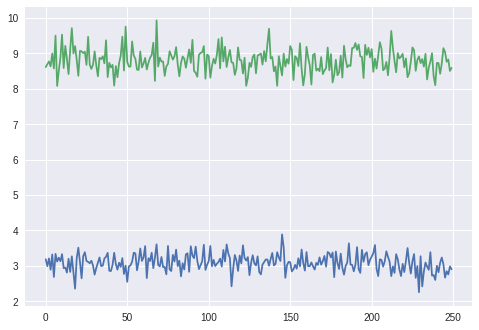

In [47]:
plt.plot(np.squeeze(inputs[:,:,5]))
plt.plot(np.squeeze(inputs[:,:,4]))

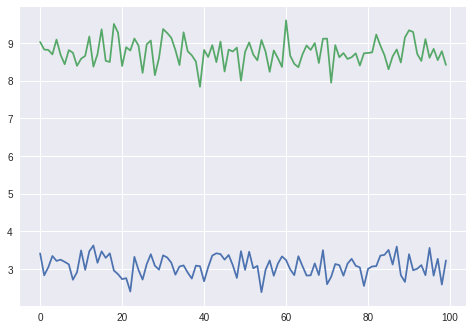

In [48]:
plt.plot(np.squeeze(targets[:,:,5]))
plt.plot(np.squeeze(targets[:,:,4]))

In [0]:
model_name = "transformer" # LSTMSeq2seqAttention
hparams_set = "transformer_base" # lstm_attention
prob_name = "timeseries_synthetic_data_series10_samples100k"

In [0]:
hparams = trainer_lib.create_hparams(hparams_set, data_dir=data_dir, problem_name=prob_name)

In [22]:
timeseries_model = registry.model(model_name)(hparams, Modes.TRAIN)

INFO:tensorflow:Setting T2TModel mode to 'train'


In [23]:
hparams.batch_size

4096

In [0]:
hparams.batch_size = 1

In [25]:
train_data_set = wave_problem.dataset(Modes.TRAIN, data_dir)

INFO:tensorflow:Reading data files from /root/t2t/data/timeseries_synthetic_data_series10_samples100k-train*
INFO:tensorflow:partition: 0 num_data_files: 9


In [0]:
BATCH_SIZE = 1
train_data_set = train_data_set.repeat(None).batch(BATCH_SIZE)

In [0]:
optimizer = tf.train.AdamOptimizer()

In [0]:
@tfe.implicit_value_and_gradients
def loss_fn(features):
  _, losses = timeseries_model(features)
  return losses["training"]

def train_model():
  # Train
  NUM_STEPS = 50

  for count, example in enumerate(tfe.Iterator(train_data_set)):
    #example["targets"] = tf.reshape(example["targets"], [BATCH_SIZE, 1, 1, 1])  # Make it 4D.
    #print(example["inputs"].shape)
    #print(example["targets"].shape)
    loss, gv = loss_fn(example)
    optimizer.apply_gradients(gv)

    if count % 25 == 0:
      print("Step: %d, Loss: %.3f" % (count, loss.numpy()))
    if count >= NUM_STEPS:
      break

In [29]:
train_model()

INFO:tensorflow:Transforming feature 'inputs' with real_l2_loss_modality.bottom
INFO:tensorflow:Transforming 'targets' with real_l2_loss_modality.targets_bottom
INFO:tensorflow:Building model body
INFO:tensorflow:Transforming body output with real_l2_loss_modality.top
Step: 0, Loss: 230.297
Step: 25, Loss: 12.436
Step: 50, Loss: 6.015


In [0]:
def test_model():
  timeseries_model.set_mode(Modes.EVAL)
  test_data_set = wave_problem.dataset(Modes.EVAL, data_dir)
  metrics_accum, metrics_result = metrics.create_eager_metrics([metrics.Metrics.RMSE, metrics.Metrics.R2])
  
  for count, example in enumerate(tfe.Iterator(test_data_set)):
    if count >= 20:
      break
    #print(example["inputs"].shape)
    #print(example["targets"].shape)
    # Make the inputs and targets 4D
    example["inputs"] = tf.reshape(example["inputs"], [1, 250, 1, 10])
    example["targets"] = tf.reshape(example["targets"], [1, 100, 1, 10])

    # Call the model
    predictions, _ = timeseries_model(example)

    # Compute and accumulate metrics
    metrics_accum(predictions, example["targets"])

  # Print out the averaged metric values on the eval data
  for name, val in metrics_result().items():
    print("%s - %s: %.2f" % (model_name, name, val))

In [31]:
test_model()

INFO:tensorflow:Setting T2TModel mode to 'eval'
INFO:tensorflow:Setting hparams.layer_prepostprocess_dropout to 0.0
INFO:tensorflow:Setting hparams.symbol_dropout to 0.0
INFO:tensorflow:Setting hparams.label_smoothing to 0.0
INFO:tensorflow:Setting hparams.attention_dropout to 0.0
INFO:tensorflow:Setting hparams.dropout to 0.0
INFO:tensorflow:Setting hparams.relu_dropout to 0.0
INFO:tensorflow:Reading data files from /root/t2t/data/timeseries_synthetic_data_series10_samples100k-dev*
INFO:tensorflow:partition: 0 num_data_files: 1
transformer - r_squared: 0.96
transformer - rmse: 1.43


In [52]:
model_name = "lstm_seq2seq"
hparams_set = "lstm_seq2seq"
hparams = trainer_lib.create_hparams(hparams_set, data_dir=data_dir, problem_name=prob_name)
hparams.batch_size = 1
timeseries_model = registry.model(model_name)(hparams, Modes.TRAIN)
train_model()
test_model()

Step: 0, Loss: 206.372
Step: 25, Loss: 52.357
Step: 50, Loss: 45.433
INFO:tensorflow:Reading data files from /root/t2t/data/timeseries_synthetic_data_series10_samples100k-dev*
INFO:tensorflow:partition: 0 num_data_files: 1
lstm_seq2seq - r_squared: 0.73
lstm_seq2seq - rmse: 4.47
